# Казанцев Данила Игоревич Лаба 6 группа М8О-407Б-21

In [1]:
!pip install --upgrade torch torchvision torchmetrics kaggle scikit-learn matplotlib


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/13/85/6c1092d4b06c3db1ed23d4106488750917156af0b24ab0a2d9951830b0e9/torch-2.7.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torch-2.7.0-cp311-cp311-win_amd64.whl.metadata (29 kB)
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e4/cf/8f9305cc0ea26badbbb3558ecae54c04a245429f03168f7fad502f8a5b25/torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata
  Using cached torchvision-0.22.0-cp311-cp311-win_amd64.whl.metadata (6.3 kB)
  Obtaining dependency information for torchmetrics from https://files.pythonhosted.org/packages/e0/ee/4d0a7213a6f412afb3483031009a3b970dd7bed3be24de95ab04fba1c05a/torchmetrics-1.7.1-py3-none-any.whl.metadata
  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Obtaining dependency information for kaggle from https://files.pythonhosted.org/packages/14/83/7f29c7abe0d5dc769dad7da993382c3e4239ad63e1dd58414d129e0a4


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import zipfile, os, shutil, random, pathlib



DATA_DIR = pathlib.Path("./archive/realwaste-main/RealWaste")
all_images = []
for class_idx, class_name in enumerate(sorted(p.name for p in DATA_DIR.iterdir())):
    for img_path in (DATA_DIR / class_name).glob("*"):
        all_images.append((img_path, class_idx, class_name))

df = pd.DataFrame(all_images, columns=["path", "label", "class"])
train_df, tmp_df = train_test_split(
    df, test_size=0.30, random_state=42, stratify=df["label"]
)
val_df, test_df  = train_test_split(
    tmp_df, test_size=0.50, random_state=42, stratify=tmp_df["label"]
)
print(f"train {len(train_df)}, val {len(val_df)}, test {len(test_df)}")



train 3326, val 713, test 713


In [2]:
import torch
from torchvision import transforms
from PIL import Image

IMG_SIZE = 224
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])
val_tfms = transforms.Compose([
    transforms.Resize(IMG_SIZE + 32),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

class DFImageDataset(torch.utils.data.Dataset):
    def __init__(self, df, tfms):
        self.df = df.reset_index(drop=True)
        self.tfms = tfms
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.path).convert("RGB")
        return self.tfms(img), row.label

train_ds = DFImageDataset(train_df, train_tfms)
val_ds   = DFImageDataset(val_df,   val_tfms)
test_ds  = DFImageDataset(test_df,  val_tfms)

batch_size = 32
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size,
                                       shuffle=True,  num_workers=0, pin_memory=True, persistent_workers = False)
val_dl   = torch.utils.data.DataLoader(val_ds,   batch_size=batch_size,
                                       shuffle=False, num_workers=0, pin_memory=True, persistent_workers = False)
test_dl  = torch.utils.data.DataLoader(test_ds,  batch_size=batch_size,
                                       shuffle=False, num_workers=0, pin_memory=True, persistent_workers = False)


In [3]:
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassConfusionMatrix,
)

NUM_CLASSES = len(train_df["label"].unique())

# ­--- создаём метрики ---
metrics = {
    "acc"      : MulticlassAccuracy(num_classes=NUM_CLASSES, average="micro"),   # обычный accuracy
    "f1_macro" : MulticlassF1Score(num_classes=NUM_CLASSES, average="macro"),
    "f1_weight": MulticlassF1Score(num_classes=NUM_CLASSES, average="weighted"),
    "top3"     : MulticlassAccuracy(num_classes=NUM_CLASSES, top_k=3),           # top-3 accuracy
    "cm"       : MulticlassConfusionMatrix(num_classes=NUM_CLASSES, normalize=None),
}

# переносим на GPU (если есть)
device = "cuda" if torch.cuda.is_available() else "cpu"
for m in metrics.values():
    m.to(device)
print(device)

cuda


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


2.7.0+cu118
True
NVIDIA GeForce RTX 4060


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm

def train_one_epoch(model, dl, optimizer, scheduler, device):
    model.train()
    run_loss = 0.0
    for xb, yb in tqdm(dl, leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        preds = model(xb)
        loss = F.cross_entropy(preds, yb)
        loss.backward()
        optimizer.step()
        run_loss += loss.item() * xb.size(0)
    if scheduler: scheduler.step()
    return run_loss / len(dl.dataset)

@torch.no_grad()
def evaluate(model, dl, device):
    for m in metrics.values():          # 6.1 — обнуляем
        m.reset()

    model.eval()
    run_loss = 0.0
    for xb, yb in dl:                   # 6.2 — прямой проход
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        logits = model(xb)
        run_loss += F.cross_entropy(logits, yb, reduction="sum").item()
        for m in metrics.values():      # 6.3 — обновляем все метрики
            m.update(logits, yb)

    # 6.4 — собираем результаты
    res = {"loss": run_loss / len(dl.dataset)}
    for k, m in metrics.items():
        res[k] = m.compute().cpu().numpy() if k == "cm" else m.compute().item()
    return res


In [8]:
from torchvision.models import resnet18, ResNet18_Weights

cnn = resnet18(weights=ResNet18_Weights.DEFAULT)
cnn.fc = nn.Linear(cnn.fc.in_features, NUM_CLASSES)
cnn = cnn.to(device)

optimizer = torch.optim.AdamW(cnn.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3,
    steps_per_epoch=len(train_dl), epochs=15
)

for epoch in range(15):
    t_loss = train_one_epoch(cnn, train_dl, optimizer, scheduler, device)
    val_stats = evaluate(cnn, val_dl, device)
    print(
        f"[{epoch+1:02d}] "
        f"loss_tr={t_loss:.3f} | loss_val={val_stats['loss']:.3f} | "
        f"Acc={val_stats['acc']:.3%} | "
        f"F1(ma)={val_stats['f1_macro']:.3%} | F1(we)={val_stats['f1_weight']:.3%} | "
        f"Top-3={val_stats['top3']:.3%}"
    )


  0%|          | 0/104 [00:00<?, ?it/s]

[01] loss_tr=1.291 | loss_val=0.722 | Acc=74.614% | F1(ma)=73.700% | F1(we)=74.099% | Top-3=94.689%


  0%|          | 0/104 [00:00<?, ?it/s]

[02] loss_tr=0.677 | loss_val=0.517 | Acc=83.450% | F1(ma)=82.955% | F1(we)=83.433% | Top-3=96.241%


  0%|          | 0/104 [00:00<?, ?it/s]

[03] loss_tr=0.515 | loss_val=0.424 | Acc=86.255% | F1(ma)=85.968% | F1(we)=86.235% | Top-3=97.378%


  0%|          | 0/104 [00:00<?, ?it/s]

[04] loss_tr=0.417 | loss_val=0.367 | Acc=87.798% | F1(ma)=87.406% | F1(we)=87.731% | Top-3=97.883%


  0%|          | 0/104 [00:00<?, ?it/s]

[05] loss_tr=0.350 | loss_val=0.344 | Acc=88.499% | F1(ma)=88.062% | F1(we)=88.434% | Top-3=98.896%


  0%|          | 0/104 [00:00<?, ?it/s]

[06] loss_tr=0.294 | loss_val=0.328 | Acc=89.060% | F1(ma)=88.989% | F1(we)=88.931% | Top-3=98.447%


  0%|          | 0/104 [00:00<?, ?it/s]

[07] loss_tr=0.258 | loss_val=0.333 | Acc=87.377% | F1(ma)=87.345% | F1(we)=87.356% | Top-3=98.300%


  0%|          | 0/104 [00:00<?, ?it/s]

[08] loss_tr=0.230 | loss_val=0.293 | Acc=89.762% | F1(ma)=89.123% | F1(we)=89.670% | Top-3=98.827%


  0%|          | 0/104 [00:00<?, ?it/s]

[09] loss_tr=0.205 | loss_val=0.291 | Acc=90.182% | F1(ma)=89.966% | F1(we)=90.080% | Top-3=98.847%


  0%|          | 0/104 [00:00<?, ?it/s]

[10] loss_tr=0.185 | loss_val=0.293 | Acc=89.902% | F1(ma)=89.663% | F1(we)=89.835% | Top-3=98.806%


  0%|          | 0/104 [00:00<?, ?it/s]

[11] loss_tr=0.178 | loss_val=0.266 | Acc=90.884% | F1(ma)=90.623% | F1(we)=90.747% | Top-3=99.145%


  0%|          | 0/104 [00:00<?, ?it/s]

[12] loss_tr=0.163 | loss_val=0.271 | Acc=90.603% | F1(ma)=90.683% | F1(we)=90.530% | Top-3=99.375%


  0%|          | 0/104 [00:00<?, ?it/s]

[13] loss_tr=0.161 | loss_val=0.285 | Acc=90.743% | F1(ma)=90.760% | F1(we)=90.655% | Top-3=98.491%


  0%|          | 0/104 [00:00<?, ?it/s]

[14] loss_tr=0.138 | loss_val=0.256 | Acc=91.024% | F1(ma)=90.793% | F1(we)=90.973% | Top-3=98.855%


  0%|          | 0/104 [00:00<?, ?it/s]

[15] loss_tr=0.126 | loss_val=0.243 | Acc=91.164% | F1(ma)=90.752% | F1(we)=91.115% | Top-3=99.391%


In [11]:
from torchvision.models import vit_b_16, ViT_B_16_Weights

vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
vit.heads.head = nn.Linear(vit.heads.head.in_features, NUM_CLASSES)
vit = vit.to(device)

optimizer = torch.optim.AdamW(vit.parameters(), lr=5e-5, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

for epoch in range(5):
    t_loss = train_one_epoch(vit, train_dl, optimizer, scheduler, device)
    val_stats = evaluate(vit, val_dl, device)
    print(
        f"[{epoch+1:02d}] "
        f"loss_tr={t_loss:.3f} | loss_val={val_stats['loss']:.3f} | "
        f"Acc={val_stats['acc']:.3%} | "
        f"F1(ma)={val_stats['f1_macro']:.3%} | F1(we)={val_stats['f1_weight']:.3%} | "
        f"Top-3={val_stats['top3']:.3%}"
    )


  0%|          | 0/104 [00:00<?, ?it/s]

[01] loss_tr=0.834 | loss_val=0.487 | Acc=82.188% | F1(ma)=82.049% | F1(we)=81.800% | Top-3=98.285%


  0%|          | 0/104 [00:00<?, ?it/s]

[02] loss_tr=0.328 | loss_val=0.398 | Acc=86.115% | F1(ma)=85.767% | F1(we)=86.173% | Top-3=98.353%


  0%|          | 0/104 [00:00<?, ?it/s]

[03] loss_tr=0.241 | loss_val=0.289 | Acc=90.042% | F1(ma)=90.171% | F1(we)=90.034% | Top-3=98.436%


  0%|          | 0/104 [00:00<?, ?it/s]

[04] loss_tr=0.166 | loss_val=0.270 | Acc=91.445% | F1(ma)=90.951% | F1(we)=91.392% | Top-3=98.463%


  0%|          | 0/104 [00:00<?, ?it/s]

[05] loss_tr=0.114 | loss_val=0.228 | Acc=92.567% | F1(ma)=92.350% | F1(we)=92.555% | Top-3=99.104%


ResNet-18 — test:
acc: 91.304%
f1_macro: 91.663%
f1_weight: 91.261%
top3: 98.900%


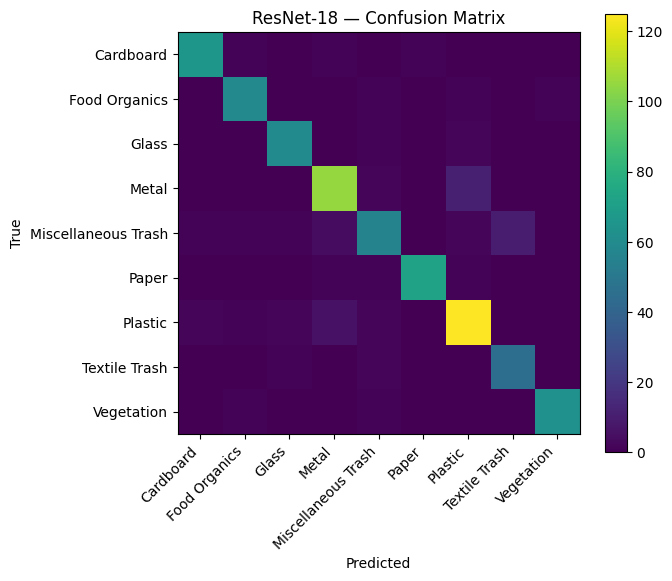


ViT-B/16 — test:
acc: 92.707%
f1_macro: 93.172%
f1_weight: 92.712%
top3: 99.852%


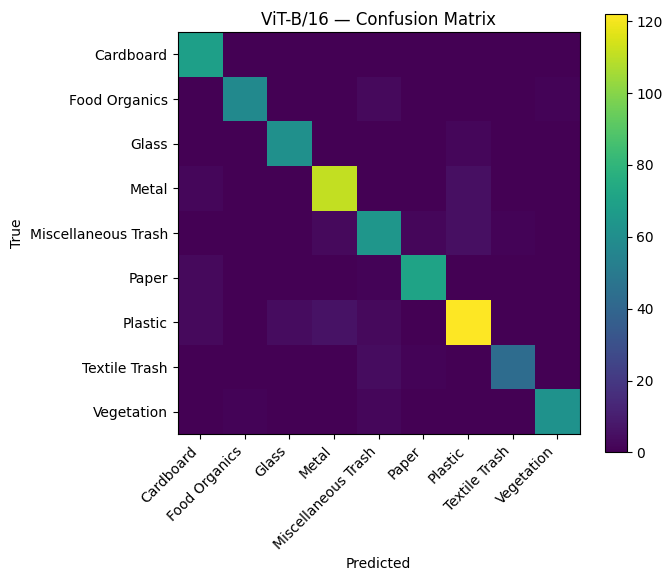

In [12]:
test_cnn = evaluate(cnn, test_dl, device)
test_vit = evaluate(vit, test_dl, device)

def show_cm(cm, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = range(NUM_CLASSES)
    names = sorted(train_df['class'].unique())
    plt.xticks(ticks, names, rotation=45, ha="right")
    plt.yticks(ticks, names)
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

print("ResNet-18 — test:")
for k in ["acc","f1_macro","f1_weight","top3"]:
    print(f"{k}: {test_cnn[k]:.3%}")
show_cm(test_cnn["cm"], "ResNet-18 — Confusion Matrix")

print("\nViT-B/16 — test:")
for k in ["acc","f1_macro","f1_weight","top3"]:
    print(f"{k}: {test_vit[k]:.3%}")
show_cm(test_vit["cm"], "ViT-B/16 — Confusion Matrix")


# Улучшения бейзлайна

In [20]:
import torch, platform, random, time, numpy as np
import torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from torchvision.transforms import v2                # новая API
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score, MulticlassConfusionMatrix
)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device =", device)

NUM_CLASSES = len(train_df["label"].unique())


device = cuda


### Аугментация

In [27]:
IMG_SIZE = 224
train_tfms = v2.Compose([
    v2.Resize(int(IMG_SIZE*1.15), antialias=True),
    v2.RandomCrop(IMG_SIZE),
    v2.RandAugment(num_ops=2, magnitude=7),
    v2.ColorJitter(0.2, 0.2, 0.2, 0.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
val_tfms = v2.Compose([
    v2.Resize(int(IMG_SIZE*1.15), antialias=True),
    v2.CenterCrop(IMG_SIZE),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

# обновляем объекты Dataset
train_ds.tfms = train_tfms
val_ds.tfms   = val_tfms
test_ds.tfms  = val_tfms

mixup_fn = v2.MixUp(alpha=0.4, num_classes=NUM_CLASSES)


In [28]:
NUM_WORKERS = 0
BATCH = 32

# веса классов для sampler и label smoothing loss
class_cnt = train_df["label"].value_counts().sort_index().values
class_w   = 1. / torch.tensor(class_cnt, dtype=torch.float)
loss_fn   = nn.CrossEntropyLoss(weight=class_w.to(device),
                                label_smoothing=0.1)

sample_w = class_w[train_df["label"].values]
sampler  = WeightedRandomSampler(sample_w, len(sample_w), replacement=True)

train_dl = DataLoader(train_ds, batch_size=BATCH, sampler=sampler,
                      num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
val_dl   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))
test_dl  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False,
                      num_workers=NUM_WORKERS, pin_memory=(device.type=="cuda"))


In [29]:
metrics = {
    "acc"      : MulticlassAccuracy(num_classes=NUM_CLASSES, average="micro").to(device),
    "f1_macro" : MulticlassF1Score(num_classes=NUM_CLASSES, average="macro").to(device),
    "f1_weight": MulticlassF1Score(num_classes=NUM_CLASSES, average="weighted").to(device),
    "top3"     : MulticlassAccuracy(num_classes=NUM_CLASSES, top_k=3).to(device),
    "cm"       : MulticlassConfusionMatrix(num_classes=NUM_CLASSES).to(device),
}


In [47]:


scaler = torch.amp.GradScaler()

def train_one_epoch(model, loader, opt, sch=None):
    model.train(); run_loss = 0.0
    for xb, yb in tqdm(loader, leave=False):
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        xb, yb = mixup_fn(xb, yb)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type="cuda"):
            preds = model(xb)
            loss  = loss_fn(preds, yb)
        scaler.scale(loss).backward()
        scaler.step(opt); scaler.update()
        run_loss += loss.item() * xb.size(0)
    if sch: sch.step()
    return run_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    for m in metrics.values(): m.reset()
    model.eval(); run_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        with torch.amp.autocast(device_type="cuda"):
            preds = model(xb)
            loss  = loss_fn(preds, yb)
        run_loss += loss.item() * xb.size(0)
        for m in metrics.values(): m.update(preds, yb)
    res = {"loss": run_loss / len(loader.dataset)}
    for k,m in metrics.items():
        res[k] = m.compute().cpu().numpy() if k=="cm" else m.compute().item()
    return res


### resnet

In [48]:
from torchvision.models import resnet18, ResNet18_Weights
import time

res = resnet18(weights=ResNet18_Weights.DEFAULT)
res.fc = nn.Linear(res.fc.in_features, NUM_CLASSES)
res = res.to(device)

opt_res = torch.optim.AdamW(res.parameters(), lr=1e-4, weight_decay=1e-4)
sch_res = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt_res, T_0=10)

for epoch in range(15):
    t0 = time.time()
    loss_tr = train_one_epoch(res, train_dl, opt_res, sch_res)
    val     = evaluate(res, val_dl)
    print(
        f"[{epoch:02d}] "
        f"loss_tr={loss_tr:.3f} | loss_val={val['loss']:.3f} | "
        f"Acc={val['acc']:.3%} | "
        f"F1(ma)={val['f1_macro']:.3%} | F1(we)={val['f1_weight']:.3%} | "
        f"Top-3={val['top3']:.3%} | time={time.time()-t0:.1f}s"
    )


  0%|          | 0/104 [00:00<?, ?it/s]

[00] loss_tr=0.005 | loss_val=1.056 | Acc=74.334% | F1(ma)=75.291% | F1(we)=74.013% | Top-3=95.454% | time=39.8s


  0%|          | 0/104 [00:00<?, ?it/s]

[01] loss_tr=0.004 | loss_val=0.974 | Acc=78.822% | F1(ma)=79.602% | F1(we)=78.351% | Top-3=96.608% | time=39.1s


  0%|          | 0/104 [00:00<?, ?it/s]

[02] loss_tr=0.003 | loss_val=0.949 | Acc=78.962% | F1(ma)=78.764% | F1(we)=78.776% | Top-3=97.366% | time=38.3s


  0%|          | 0/104 [00:00<?, ?it/s]

[03] loss_tr=0.003 | loss_val=0.888 | Acc=84.712% | F1(ma)=85.193% | F1(we)=84.461% | Top-3=97.992% | time=39.1s


  0%|          | 0/104 [00:00<?, ?it/s]

[04] loss_tr=0.003 | loss_val=0.896 | Acc=83.731% | F1(ma)=83.980% | F1(we)=83.550% | Top-3=98.121% | time=40.2s


  0%|          | 0/104 [00:00<?, ?it/s]

[05] loss_tr=0.003 | loss_val=0.853 | Acc=86.396% | F1(ma)=86.559% | F1(we)=86.253% | Top-3=98.192% | time=39.8s


  0%|          | 0/104 [00:00<?, ?it/s]

[06] loss_tr=0.003 | loss_val=0.848 | Acc=85.694% | F1(ma)=86.052% | F1(we)=85.483% | Top-3=98.272% | time=40.2s


  0%|          | 0/104 [00:00<?, ?it/s]

[07] loss_tr=0.003 | loss_val=0.847 | Acc=86.115% | F1(ma)=86.220% | F1(we)=85.989% | Top-3=98.329% | time=40.7s


  0%|          | 0/104 [00:00<?, ?it/s]

[08] loss_tr=0.003 | loss_val=0.831 | Acc=86.676% | F1(ma)=86.887% | F1(we)=86.562% | Top-3=98.583% | time=39.9s


  0%|          | 0/104 [00:00<?, ?it/s]

[09] loss_tr=0.003 | loss_val=0.820 | Acc=87.798% | F1(ma)=88.044% | F1(we)=87.728% | Top-3=98.799% | time=40.0s


  0%|          | 0/104 [00:00<?, ?it/s]

[10] loss_tr=0.003 | loss_val=0.871 | Acc=84.712% | F1(ma)=84.691% | F1(we)=84.659% | Top-3=97.607% | time=39.7s


  0%|          | 0/104 [00:00<?, ?it/s]

[11] loss_tr=0.003 | loss_val=0.888 | Acc=84.011% | F1(ma)=83.928% | F1(we)=83.978% | Top-3=97.870% | time=40.1s


  0%|          | 0/104 [00:00<?, ?it/s]

[12] loss_tr=0.003 | loss_val=0.861 | Acc=86.816% | F1(ma)=86.951% | F1(we)=86.750% | Top-3=98.685% | time=39.8s


  0%|          | 0/104 [00:00<?, ?it/s]

[13] loss_tr=0.003 | loss_val=0.887 | Acc=84.572% | F1(ma)=84.684% | F1(we)=84.436% | Top-3=98.315% | time=39.3s


  0%|          | 0/104 [00:00<?, ?it/s]

[14] loss_tr=0.003 | loss_val=0.817 | Acc=88.079% | F1(ma)=88.054% | F1(we)=88.052% | Top-3=98.819% | time=38.9s


### ViT-B/16

In [49]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
import time

vit = vit_b_16(weights=ViT_B_16_Weights.DEFAULT)
vit.heads.head = nn.Linear(vit.heads.head.in_features, NUM_CLASSES)
vit = vit.to(device)

opt_vit = torch.optim.AdamW(vit.parameters(), lr=5e-5, weight_decay=1e-4)
sch_vit = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt_vit, T_0=10)

for epoch in range(15):
    t0 = time.time()
    loss_tr = train_one_epoch(vit, train_dl, opt_vit, sch_vit)
    val     = evaluate(vit, val_dl)
    print(
        f"[{epoch:02d}] "
        f"loss_tr={loss_tr:.3f} | loss_val={val['loss']:.3f} | "
        f"Acc={val['acc']:.3%} | "
        f"F1(ma)={val['f1_macro']:.3%} | F1(we)={val['f1_weight']:.3%} | "
        f"Top-3={val['top3']:.3%} | time={time.time()-t0:.1f}s"
    )


  0%|          | 0/104 [00:00<?, ?it/s]

[00] loss_tr=0.004 | loss_val=0.999 | Acc=75.877% | F1(ma)=76.445% | F1(we)=74.648% | Top-3=95.862% | time=82.0s


  0%|          | 0/104 [00:00<?, ?it/s]

[01] loss_tr=0.004 | loss_val=0.826 | Acc=85.414% | F1(ma)=85.959% | F1(we)=85.153% | Top-3=98.802% | time=93.4s


  0%|          | 0/104 [00:00<?, ?it/s]

[02] loss_tr=0.003 | loss_val=0.819 | Acc=84.993% | F1(ma)=85.295% | F1(we)=84.617% | Top-3=97.866% | time=77.5s


  0%|          | 0/104 [00:00<?, ?it/s]

[03] loss_tr=0.003 | loss_val=0.731 | Acc=88.920% | F1(ma)=89.805% | F1(we)=88.810% | Top-3=98.858% | time=79.4s


  0%|          | 0/104 [00:00<?, ?it/s]

[04] loss_tr=0.003 | loss_val=0.757 | Acc=88.079% | F1(ma)=88.178% | F1(we)=87.928% | Top-3=99.364% | time=78.7s


  0%|          | 0/104 [00:00<?, ?it/s]

[05] loss_tr=0.003 | loss_val=0.703 | Acc=90.743% | F1(ma)=91.534% | F1(we)=90.688% | Top-3=99.743% | time=77.9s


  0%|          | 0/104 [00:00<?, ?it/s]

[06] loss_tr=0.003 | loss_val=0.684 | Acc=92.146% | F1(ma)=92.599% | F1(we)=92.092% | Top-3=99.676% | time=89.0s


  0%|          | 0/104 [00:00<?, ?it/s]

[07] loss_tr=0.003 | loss_val=0.689 | Acc=91.585% | F1(ma)=92.221% | F1(we)=91.564% | Top-3=99.515% | time=79.8s


  0%|          | 0/104 [00:00<?, ?it/s]

[08] loss_tr=0.003 | loss_val=0.674 | Acc=92.567% | F1(ma)=92.921% | F1(we)=92.499% | Top-3=99.676% | time=74.5s


  0%|          | 0/104 [00:00<?, ?it/s]

[09] loss_tr=0.003 | loss_val=0.674 | Acc=92.286% | F1(ma)=92.631% | F1(we)=92.203% | Top-3=99.676% | time=79.9s


  0%|          | 0/104 [00:00<?, ?it/s]

[10] loss_tr=0.003 | loss_val=0.720 | Acc=90.182% | F1(ma)=90.754% | F1(we)=90.119% | Top-3=99.339% | time=81.7s


  0%|          | 0/104 [00:00<?, ?it/s]

[11] loss_tr=0.003 | loss_val=0.710 | Acc=90.323% | F1(ma)=91.163% | F1(we)=90.446% | Top-3=99.315% | time=70.5s


  0%|          | 0/104 [00:00<?, ?it/s]

[12] loss_tr=0.003 | loss_val=0.724 | Acc=89.201% | F1(ma)=89.402% | F1(we)=89.283% | Top-3=99.353% | time=89.5s


  0%|          | 0/104 [00:00<?, ?it/s]

[13] loss_tr=0.003 | loss_val=0.707 | Acc=91.024% | F1(ma)=91.404% | F1(we)=90.928% | Top-3=98.737% | time=105.9s


  0%|          | 0/104 [00:00<?, ?it/s]

[14] loss_tr=0.003 | loss_val=0.671 | Acc=92.847% | F1(ma)=93.212% | F1(we)=92.809% | Top-3=99.036% | time=103.8s


ResNet-18 + aug — test:
acc      : 88.359%
f1_macro : 88.846%
f1_weight: 88.278%
top3     : 97.900%


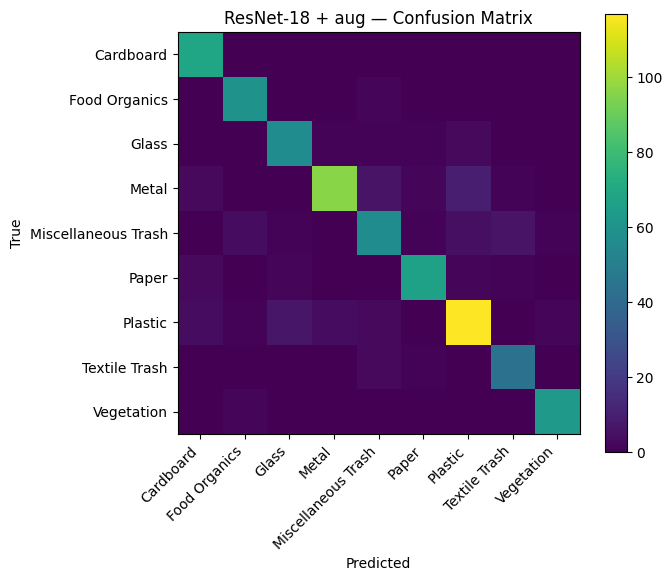


ViT-B/16 + aug — test:
acc      : 92.006%
f1_macro : 93.200%
f1_weight: 91.952%
top3     : 99.233%


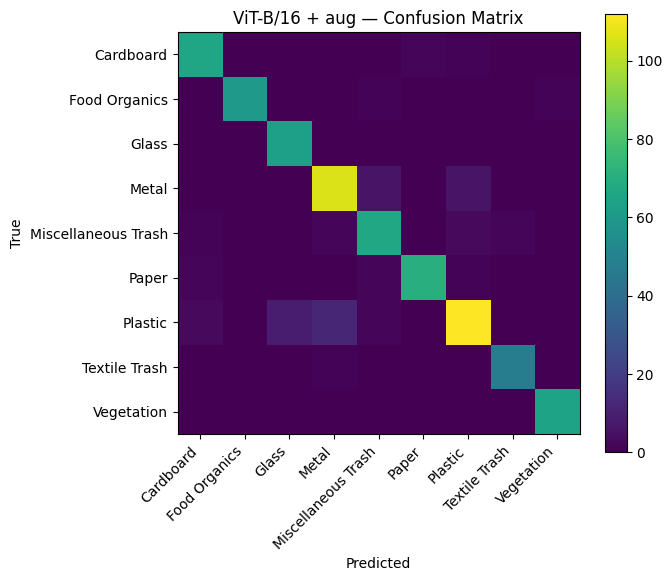

In [53]:
test_res_aug = evaluate(res, test_dl)
test_vit_aug = evaluate(vit, test_dl)


def show_cm(cm, title):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(7, 6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks  = range(NUM_CLASSES)
    names  = sorted(train_df["class"].unique())
    plt.xticks(ticks, names, rotation=45, ha="right")
    plt.yticks(ticks, names)
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout(); plt.show()


print("ResNet-18 + aug — test:")
for k in ["acc", "f1_macro", "f1_weight", "top3"]:
    print(f"{k:9s}: {test_res_aug[k]:.3%}")
show_cm(test_res_aug["cm"], "ResNet-18 + aug — Confusion Matrix")

print("\nViT-B/16 + aug — test:")
for k in ["acc", "f1_macro", "f1_weight", "top3"]:
    print(f"{k:9s}: {test_vit_aug[k]:.3%}")
show_cm(test_vit_aug["cm"], "ViT-B/16 + aug — Confusion Matrix")


#### Сравнивая с обыным бейзлайном, как будто ситуация осталась примерно такая же.